# Dataset Exploratory Data Analysis and Preprocessing

## Purpose

This script performs comprehensive exploratory data analysis (EDA) on the RealWaste dataset and prepares it for training. It handles data cleaning, visualization, and creates stratified train/validation/test splits.

## What This Script Does

The script processes the raw dataset through seven main steps:

1. **Scans the dataset** - Locates all image files and verifies their integrity
2. **Analyzes the data** - Examines class distribution, image dimensions, and identifies potential issues
3. **Creates visualizations** - Generates plots for understanding dataset characteristics
4. **Cleans the data** - Removes corrupt images, extreme cases, and duplicates
5. **Shows sample images** - Displays representative examples from each class
6. **Splits the data** - Creates stratified 70/15/15 train/val/test splits
7. **Saves processed data** - Exports cleaned manifests and metadata

---

## Configuration

Update these variables at the top of the script:

```python
DATASET_DIR = r"C:\Users\User\Desktop\CNN asignment\realwaste\realwaste-main\RealWaste"
MIN_SIZE = 32  # Minimum image dimension in pixels
RANDOM_SEED = 42  # For reproducible splits
```

---

## Output Files Generated

### Data Files
- **manifest_clean.csv** - Complete cleaned dataset with image paths and metadata
- **train_manifest.csv** - Training set (70% of data)
- **val_manifest.csv** - Validation set (15% of data)
- **test_manifest.csv** - Test set (15% of data)
- **classes.json** - List of waste category names

### Visualization Files
- **eda_analysis.png** - Four-panel figure showing:
  - Class distribution bar chart
  - Aspect ratio histogram
  - Image dimensions scatter plot
  - Width distribution by class (box plot)
  
- **sample_images_per_class.png** - Grid showing 5 sample images from each category

### Report
- **eda_report.txt** - Text summary of dataset statistics and recommendations

---

## Data Cleaning Steps

The script applies the following filters:

1. **Corrupt image removal** - Verifies each image can be opened properly
2. **Size filtering** - Removes images smaller than 32x32 pixels
3. **Aspect ratio filtering** - Removes extreme ratios (< 0.2 or > 5)
4. **Duplicate removal** - Checks for duplicate file paths

---

## Dataset Split Strategy

Uses stratified splitting to maintain class proportions:

- **Training set**: 70% - Used for model training
- **Validation set**: 15% - Used for hyperparameter tuning and model selection
- **Test set**: 15% - Used for final evaluation only

Stratification ensures each split has the same class distribution as the original dataset, which is important for handling class imbalance.

---

## How to Run

```bash
python eda_preprocessing.py
```

**Expected output:**
- Console output showing statistics at each step
- Two PNG visualization files
- Four CSV manifest files
- One JSON file with class names
- One text report

**Runtime:** 1-5 minutes 

---

## Understanding the Output

### Class Imbalance Ratio
The script calculates how imbalanced your dataset is:
- **Ratio < 2**: Well balanced, standard training should work
- **Ratio 2-5**: Moderate imbalance, use class weights
- **Ratio > 5**: Severe imbalance, consider focal loss or oversampling

### Image Dimension Statistics
Check if images are:
- Too small (may need upsampling)
- Highly variable (will be resized anyway)
- Mostly landscape or portrait (affects crop strategy)

### Aspect Ratio Analysis
Extreme ratios may indicate:
- Panoramic images (need different preprocessing)
- Incorrectly cropped images
- Data quality issues

---

## Common Issues and Solutions

**"Corrupt/Invalid" warnings:**
These images cannot be opened and are automatically excluded from the final dataset.

**Very small dataset after cleaning:**
Review the MIN_SIZE parameter. If your images are legitimately small, reduce this threshold.

**Uneven class distribution:**
This is expected with real-world waste datasets. The script will note this in the report and recommend using class weights during training.

**Missing images after running:**
Check that DATASET_DIR points to the correct folder structure:
```
RealWaste/
  ├── cardboard/
  ├── glass/
  ├── metal/
  └── ...
```

---

## Integration with Training Pipeline

After running this script, we use generated manifest files in next training codes:

```python
# Instead of scanning directories
train_df = pd.read_csv('train_manifest.csv')
val_df = pd.read_csv('val_manifest.csv')
test_df = pd.read_csv('test_manifest.csv')

# Use 'path' column for image loading
# Use 'label' column for classes
```

This ensures consistent splits across all experiments.

---

## Notes

- The script preserves the original image files (no modifications to source data)
- Splits are deterministic (same results every run with same seed)
- All statistics are saved for reference in future experiments
- The cleaning is conservative - only obvious problems are removed

STEP 1: Scanning Dataset
Found classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


✓ Total valid images: 4752
✗ Corrupt images found: 0

STEP 2: Exploratory Data Analysis

--- Class Distribution ---
label
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
dtype: int64

Imbalance Ratio: 2.90x (max/min)

--- Image Statistics ---
Width  -> min: 524, max: 524, mean: 524.0
Height -> min: 524, max: 524, mean: 524.0
Aspect Ratio -> min: 1.00, max: 1.00

--- Color Modes ---
mode
RGB    4752
Name: count, dtype: int64

STEP 3: Creating Visualizations


C:\Users\User\AppData\Local\Temp\ipykernel_23048\2737644291.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(dims_by_class, labels=labels_for_box, vert=True)


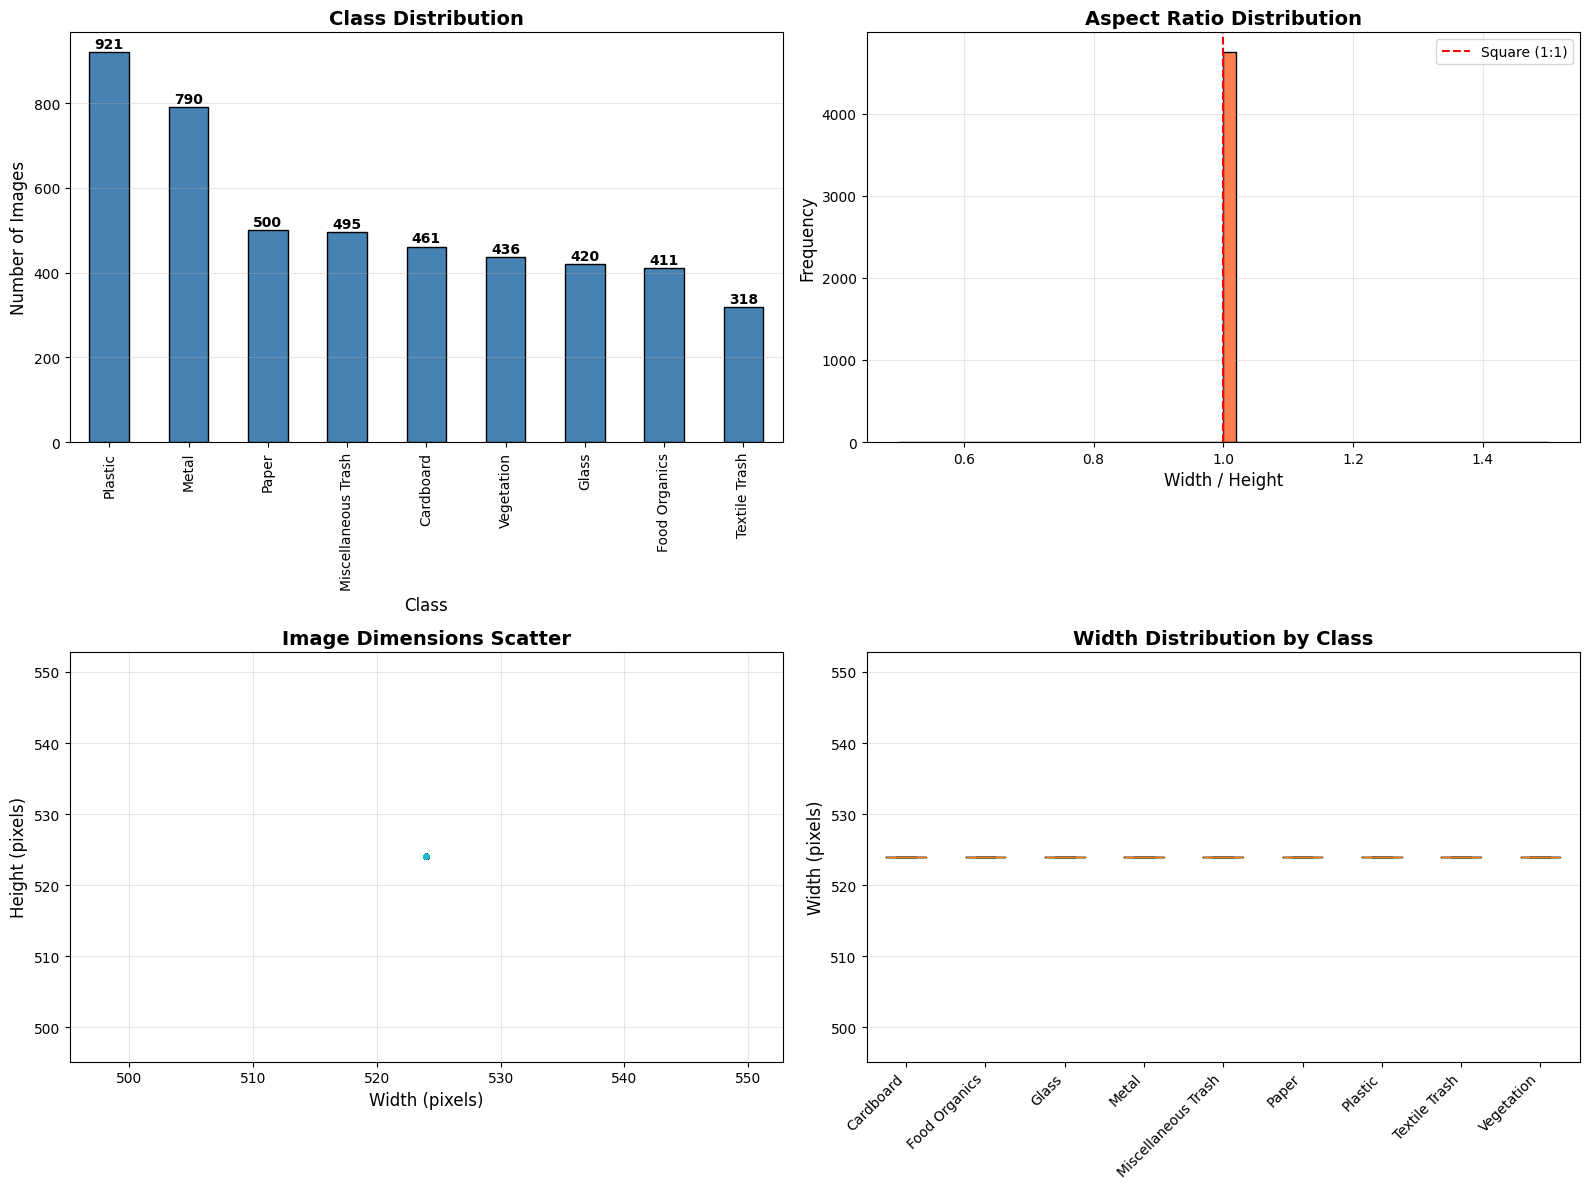


STEP 4: Data Cleaning
✓ Removed tiny images (< 32px): 0
✓ Removed extreme aspect ratios: 0
✓ Removed duplicate paths: 0

✓ Final dataset size: 4752 images

STEP 5: Sample Images per Class


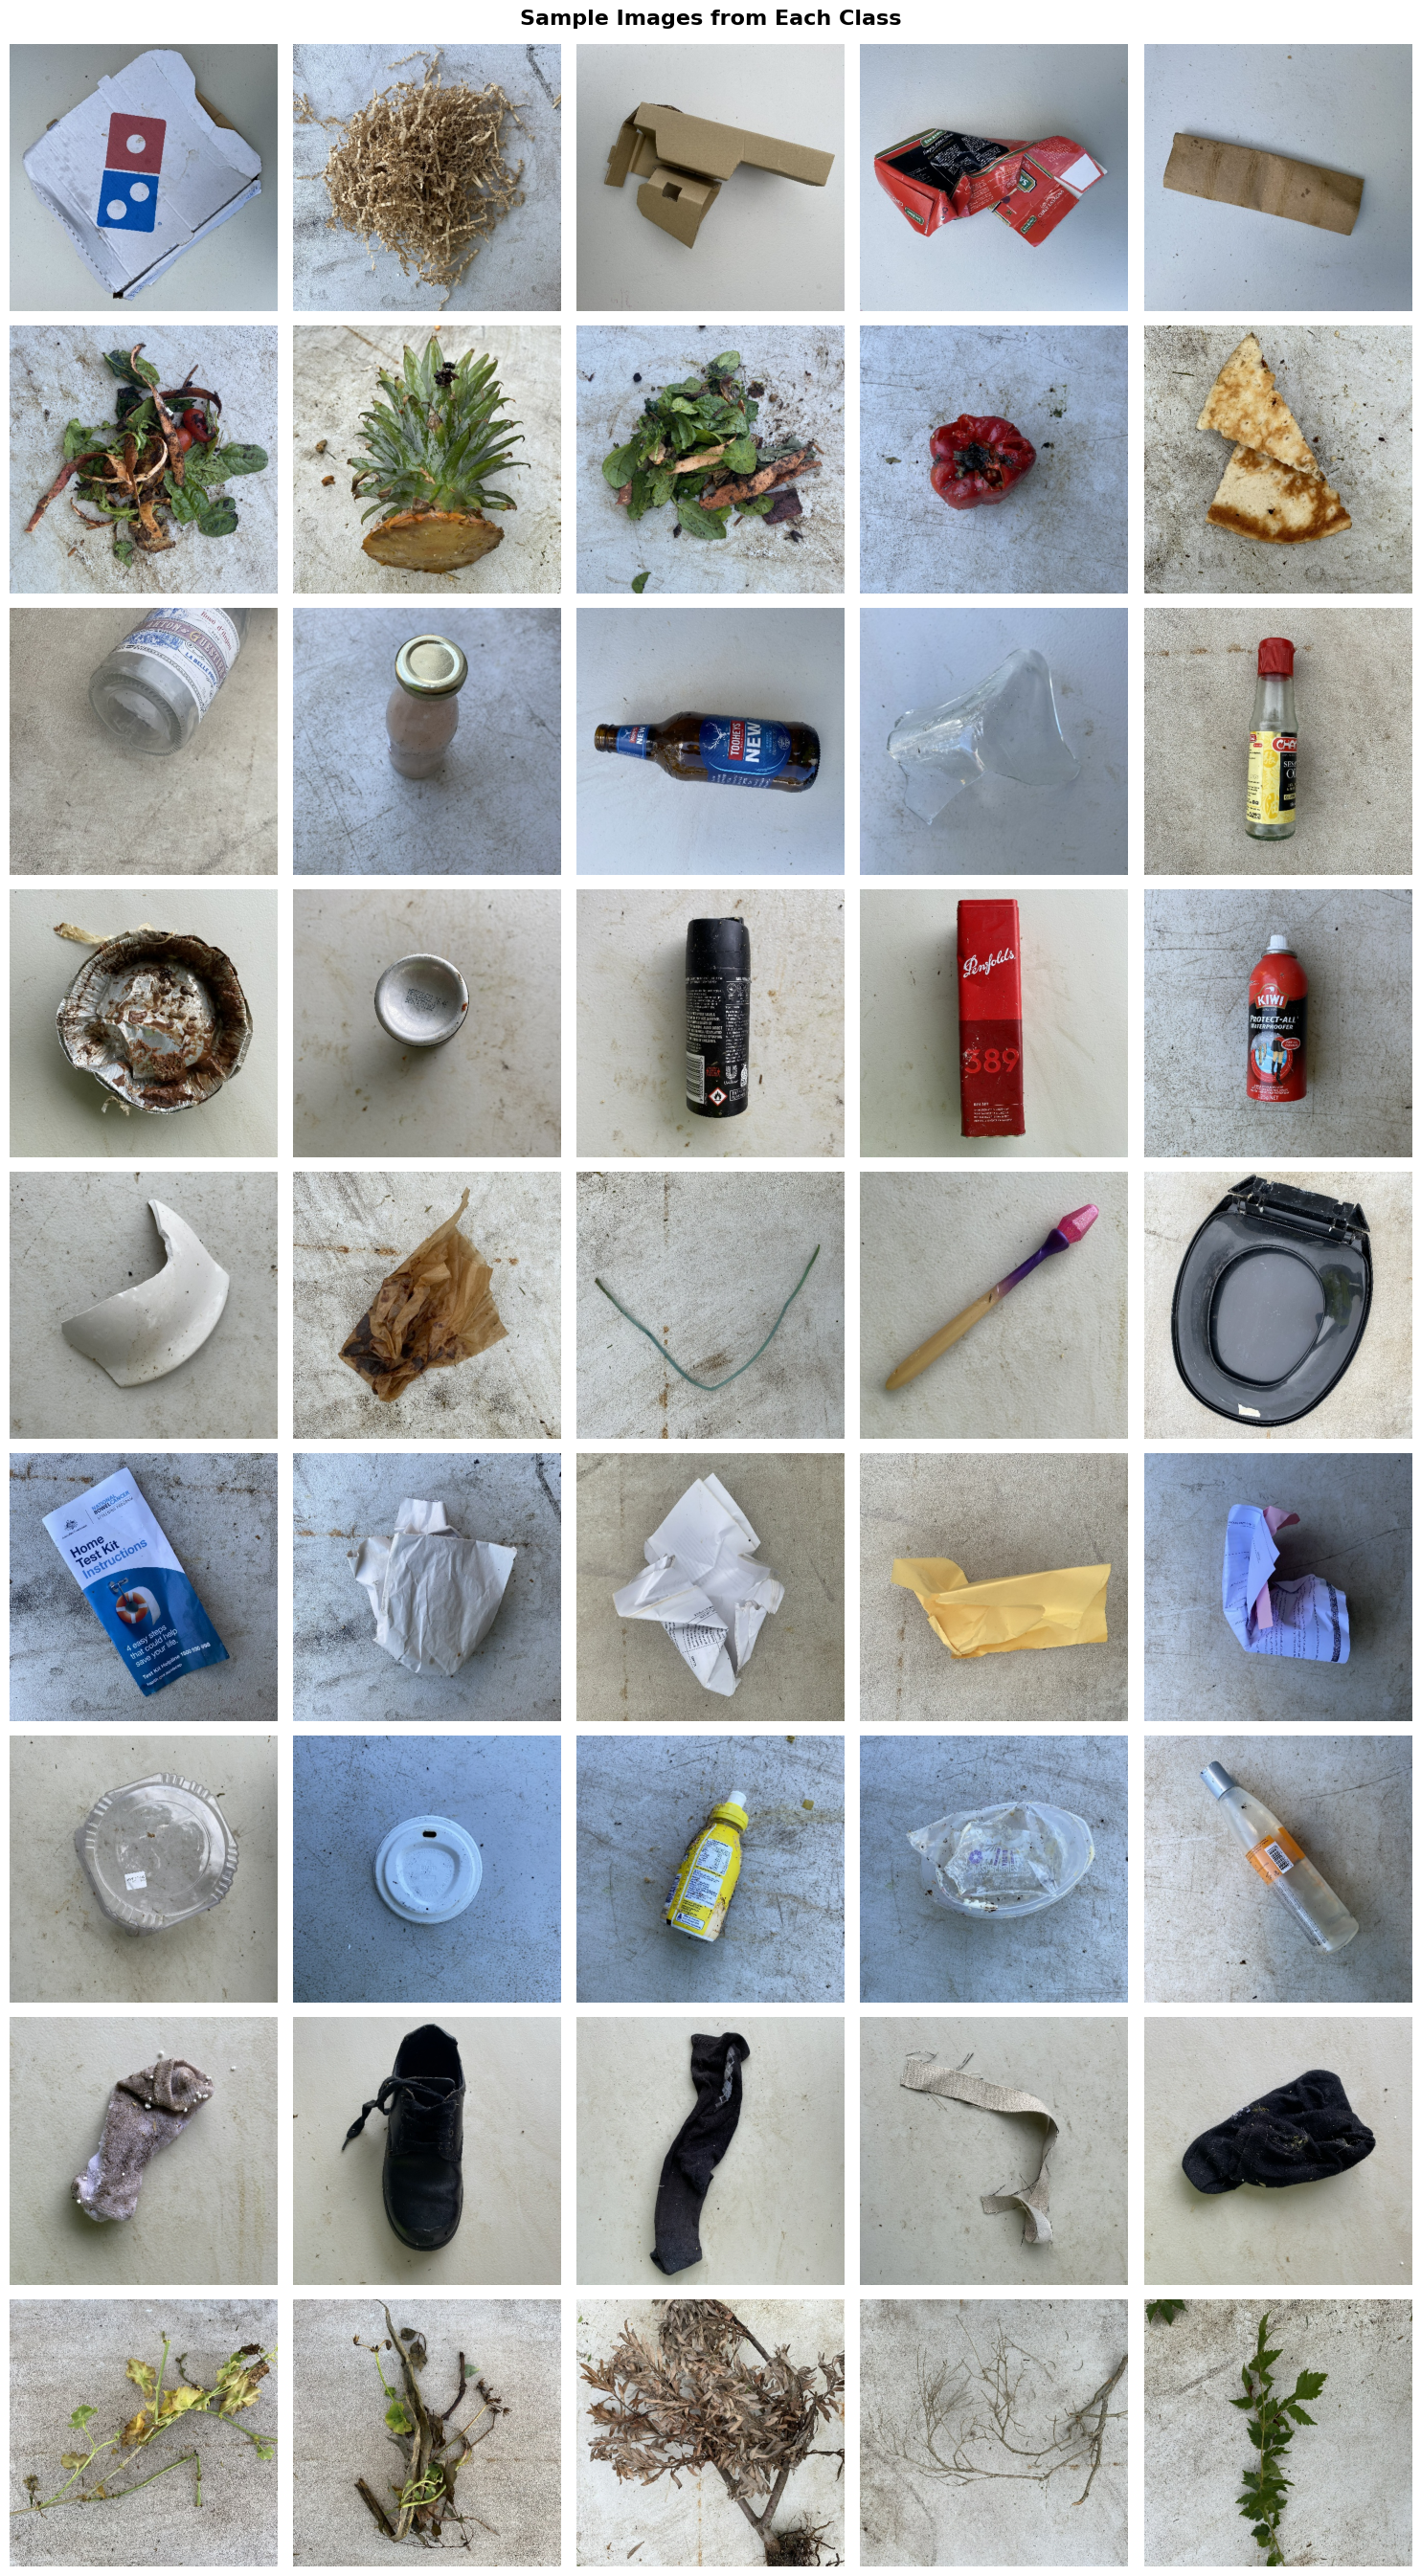


STEP 6: Creating Stratified Splits
Train: 3326 (70.0%)
Val:   713 (15.0%)
Test:  713 (15.0%)

--- Class Distribution in Splits ---
                     Train  Val  Test
label                                
Cardboard              323   69    69
Food Organics          288   61    62
Glass                  294   63    63
Metal                  553  119   118
Miscellaneous Trash    346   74    75
Paper                  350   75    75
Plastic                645  138   138
Textile Trash          222   48    48
Vegetation             305   66    65

STEP 7: Saving Processed Data
✓ Saved manifest_clean.csv
✓ Saved train_manifest.csv
✓ Saved val_manifest.csv
✓ Saved test_manifest.csv
✓ Saved classes.json

✓ Saved eda_report.txt

EDA COMPLETE!


In [ ]:
import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==========================================
# 0) Configuration
# ==========================================
DATASET_DIR = r"C:\Users\User\Desktop\CNN asignment\realwaste\realwaste-main\RealWaste"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
RANDOM_SEED = 42
MIN_SIZE = 32
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ==========================================
# 1) Scan and Build DataFrame
# ==========================================
print("="*60)
print("STEP 1: Scanning Dataset")
print("="*60)

rows = []
root = Path(DATASET_DIR)
classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
print(f"Found classes: {classes}\n")

corrupt_files = []
for cls in classes:
    cls_path = root / cls
    for p in cls_path.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                # Verify image integrity
                with Image.open(p) as im:
                    im.verify()
                # Get dimensions
                with Image.open(p) as im:
                    w, h = im.size
                    mode = im.mode
                rows.append({
                    "path": str(p),
                    "label": cls,
                    "w": w,
                    "h": h,
                    "mode": mode,
                    "aspect_ratio": w/h if h > 0 else 0
                })
            except Exception as e:
                print(f"⚠ Corrupt/Invalid: {p} -> {e}")
                corrupt_files.append(str(p))

df = pd.DataFrame(rows)
print(f"\n✓ Total valid images: {len(df)}")
print(f"✗ Corrupt images found: {len(corrupt_files)}")

# ==========================================
# 2) Enhanced EDA
# ==========================================
print("\n" + "="*60)
print("STEP 2: Exploratory Data Analysis")
print("="*60)

# Class distribution
print("\n--- Class Distribution ---")
class_counts = df.groupby("label").size().sort_values(ascending=False)
print(class_counts)

# Calculate imbalance ratio
max_samples = class_counts.max()
min_samples = class_counts.min()
imbalance_ratio = max_samples / min_samples
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}x (max/min)")

# Image statistics
print("\n--- Image Statistics ---")
print(f"Width  -> min: {df['w'].min()}, max: {df['w'].max()}, mean: {df['w'].mean():.1f}")
print(f"Height -> min: {df['h'].min()}, max: {df['h'].max()}, mean: {df['h'].mean():.1f}")
print(f"Aspect Ratio -> min: {df['aspect_ratio'].min():.2f}, max: {df['aspect_ratio'].max():.2f}")

# Color modes
print(f"\n--- Color Modes ---")
print(df['mode'].value_counts())

# ==========================================
# 3) Comprehensive Visualizations
# ==========================================
print("\n" + "="*60)
print("STEP 3: Creating Visualizations")
print("="*60)

# 3.1) Class distribution bar plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
class_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

# 3.2) Aspect ratio distribution
ax = axes[0, 1]
df['aspect_ratio'].clip(0, 4).hist(bins=50, ax=ax, color='coral', edgecolor='black')
ax.set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Width / Height', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.axvline(1, color='red', linestyle='--', label='Square (1:1)')
ax.legend()
ax.grid(alpha=0.3)

# 3.3) Image size scatter
ax = axes[1, 0]
scatter = ax.scatter(df['w'], df['h'], c=df['label'].astype('category').cat.codes, 
                    alpha=0.6, s=10, cmap='tab10')
ax.set_title('Image Dimensions Scatter', fontsize=14, fontweight='bold')
ax.set_xlabel('Width (pixels)', fontsize=12)
ax.set_ylabel('Height (pixels)', fontsize=12)
ax.grid(alpha=0.3)

# 3.4) Box plot of dimensions by class
ax = axes[1, 1]
dims_by_class = []
labels_for_box = []
for cls in classes:
    cls_df = df[df['label'] == cls]
    dims_by_class.append(cls_df['w'].values)
    labels_for_box.append(cls)
ax.boxplot(dims_by_class, labels=labels_for_box, vert=True)
ax.set_title('Width Distribution by Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Width (pixels)', fontsize=12)
ax.set_xticklabels(labels_for_box, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4) Data Cleaning Pipeline
# ==========================================
print("\n" + "="*60)
print("STEP 4: Data Cleaning")
print("="*60)

initial_count = len(df)

# 4.1) Filter tiny images
df = df[(df['w'] >= MIN_SIZE) & (df['h'] >= MIN_SIZE)].reset_index(drop=True)
print(f"✓ Removed tiny images (< {MIN_SIZE}px): {initial_count - len(df)}")

# 4.2) Filter extreme aspect ratios (based on paper recommendations)
before_ar = len(df)
df = df[(df['aspect_ratio'] > 0.2) & (df['aspect_ratio'] < 5)].reset_index(drop=True)
print(f"✓ Removed extreme aspect ratios: {before_ar - len(df)}")

# 4.3) Remove duplicates
before_dup = len(df)
df = df.drop_duplicates(subset=['path']).reset_index(drop=True)
print(f"✓ Removed duplicate paths: {before_dup - len(df)}")

print(f"\n✓ Final dataset size: {len(df)} images")

# ==========================================
# 5) Sample Images Visualization
# ==========================================
print("\n" + "="*60)
print("STEP 5: Sample Images per Class")
print("="*60)

n_cols = 5
fig, axes = plt.subplots(len(classes), n_cols, figsize=(15, 3*len(classes)))
if len(classes) == 1:
    axes = axes.reshape(1, -1)

for i, cls in enumerate(classes):
    cls_paths = df[df['label'] == cls]['path'].tolist()
    sample_paths = random.sample(cls_paths, min(n_cols, len(cls_paths)))
    
    for j, p in enumerate(sample_paths):
        img = Image.open(p).convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(cls, fontsize=12, fontweight='bold', rotation=0, 
                                  labelpad=50, ha='right')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sample_images_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 6) Stratified Train/Val/Test Split
# ==========================================
print("\n" + "="*60)
print("STEP 6: Creating Stratified Splits")
print("="*60)

from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test split
# First split: 70% train, 30% temp (for val+test)
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=RANDOM_SEED
)
# Second split: Split temp into 50-50 (15% val, 15% test of total)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=RANDOM_SEED
)

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Verify stratification
print("\n--- Class Distribution in Splits ---")
split_dist = pd.DataFrame({
    'Train': train_df['label'].value_counts().sort_index(),
    'Val': val_df['label'].value_counts().sort_index(),
    'Test': test_df['label'].value_counts().sort_index()
})
print(split_dist)

# ==========================================
# 7) Save Cleaned Data
# ==========================================
print("\n" + "="*60)
print("STEP 7: Saving Processed Data")
print("="*60)

df.to_csv('manifest_clean.csv', index=False)
train_df.to_csv('train_manifest.csv', index=False)
val_df.to_csv('val_manifest.csv', index=False)
test_df.to_csv('test_manifest.csv', index=False)

with open('classes.json', 'w') as f:
    json.dump(classes, f, indent=2)

print("✓ Saved manifest_clean.csv")
print("✓ Saved train_manifest.csv")
print("✓ Saved val_manifest.csv")
print("✓ Saved test_manifest.csv")
print("✓ Saved classes.json")

# ==========================================
# 8) Generate EDA Report
# ==========================================
report = f"""
{'='*60}
REALWASTE DATASET - EDA REPORT
{'='*60}

Dataset Statistics:
- Total Images: {len(df)}
- Number of Classes: {len(classes)}
- Classes: {', '.join(classes)}

Class Distribution:
{class_counts.to_string()}

Imbalance Ratio: {imbalance_ratio:.2f}x

Image Dimensions:
- Width:  min={df['w'].min()}, max={df['w'].max()}, mean={df['w'].mean():.1f}
- Height: min={df['h'].min()}, max={df['h'].max()}, mean={df['h'].mean():.1f}
- Aspect Ratio: min={df['aspect_ratio'].min():.2f}, max={df['aspect_ratio'].max():.2f}

Data Split:
- Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)
- Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)
- Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)

Recommendations:
1. Use weighted loss function due to class imbalance (ratio: {imbalance_ratio:.2f}x)
2. Apply aggressive data augmentation (geometric + color transforms)
3. Use larger input resolution (256x256 or 384x384) based on paper findings
4. Consider focal loss for handling class imbalance
5. Implement early stopping with patience based on validation performance

{'='*60}
"""

with open('eda_report.txt', 'w') as f:
    f.write(report)

print("\n✓ Saved eda_report.txt")
print("\n" + "="*60)
print("EDA COMPLETE!")
print("="*60)